In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import hvplot.xarray

from mlprecip_utils import *

import warnings

/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib

In [2]:
warnings.filterwarnings("ignore")

In [3]:
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]

### Read Precip Data
CPC 1/4 deg Monthly downloaded from:  https://psl.noaa.gov/data/gridded/data.unified.daily.conus.html

In [4]:
fname='/shared/obs/gridded/CPC-PRECIP-CONUS/monthly/precip.V1.0.mon.mean.nc'
ds=xr.open_dataset(fname)

### Subset to SE US

In [5]:
ds_seus=ds.sel(lat=slice(lat_reg[0],lat_reg[1]),lon=slice(lon_reg[0],lon_reg[1]))
ds_seus

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 56, time: 846)
Coordinates:
  * lat      (lat) float32 24.12 24.38 24.62 24.88 ... 35.12 35.38 35.62 35.88
  * lon      (lon) float32 269.1 269.4 269.6 269.9 ... 282.1 282.4 282.6 282.9
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2018-06-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

### Calculate anoms in SEUS Region

In [6]:
ds_anoms=ds_seus.groupby('time.month')-ds_seus.groupby('time.month').mean()
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 56, time: 846)
Coordinates:
  * lat      (lat) float32 24.12 24.38 24.62 24.88 ... 35.12 35.38 35.62 35.88
  * lon      (lon) float32 269.1 269.4 269.6 269.9 ... 282.1 282.4 282.6 282.9
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2018-06-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan ... -0.3469 -0.437 -0.5924

### Make index by averaging over region

In [7]:
ds_anoms_index=ds_anoms.mean(dim=['lat','lon'])
ds_anoms_index

<xarray.Dataset>
Dimensions:  (time: 846)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2018-06-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6
Data variables:
    precip   (time) float32 0.1632 0.4818 2.649 -0.1696 ... 0.759 1.534 -0.101

### Plot Index by Season

In [8]:
ds_anoms_index.hvplot.step(by='time.season',x='time.year',subplots=True).cols(2)

:NdLayout   [time.season]
   :Curve   [time.year]   (precip)

### Plot Seasonal Mean and Standard Deviation

In [9]:
ds_seus['precip'].mean(dim=['lat','lon']).groupby('time.season').mean().hvplot.bar(title='Seasonal Mean SEUS Precip')+\
ds_anoms_index['precip'].groupby('time.season').std().hvplot.bar(title='Seasonal Std SEUS Precip',shared_axes=False)

:Layout
   .Bars.I  :Bars   [season,Variable]   (value)
   .Bars.II :Bars   [season,Variable]   (value)

### Read Monthly Climate Indices from ESRL/PSL 
AMO, NAO, NINO34, PDO

In [10]:
indices=['amo','nao','nino34','pdo']

ds_indices_list=[]
for i in indices:
    
    df=pd.read_table('/shared/ccsm4/kpegion/obs2/CLIM_INDICES/'+i+'.txt',skiprows=1,
                     header=None,delim_whitespace=True,
                     index_col=0,parse_dates=True,
                     na_values=['-99.9','-99.90','-99.99']).dropna()
    
    start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
    end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
    dates=pd.date_range(start=start_date,end=end_date,freq='MS')
    clim_index=df.T.unstack().values
    ds_index=xr.DataArray(clim_index.astype('float'),coords={'time':dates},dims=['time'])      
    
    ds_indices_list.append(ds_index.to_dataset(name=i))

ds_indices_list.append(ds_anoms_index)

ds_indices=xr.merge(ds_indices_list).dropna(dim='time')
ds_indices

<xarray.Dataset>
Dimensions:  (time: 822)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2018-06-01
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 1.0 2.0 3.0 4.0 5.0 6.0
Data variables:
    amo      (time) float64 0.108 -0.036 -0.108 -0.133 ... 0.051 -0.013 -0.024
    nao      (time) float64 0.56 0.01 -0.78 0.65 -0.5 ... -1.38 1.2 2.02 1.41
    nino34   (time) float64 -1.99 -1.69 -1.42 -1.54 ... -0.8 -0.51 -0.2 0.04
    pdo      (time) float64 -2.13 -2.91 -1.13 -1.2 ... -0.05 0.11 0.11 -0.04
    precip   (time) float32 -0.09544 -0.8248 0.5145 ... 0.759 1.534 -0.101

### Quick Look Plots of Indices

In [11]:
ds_indices.hvplot.line(x='time',subplots=True,shared_axes=False).cols(2)

:NdLayout   [Variable]
   :Curve   [time]   (value)

### Make Composites of Precip Anomalies based on Indices

Warm 429
Neutral 387
Cold 6
<xarray.Dataset>
Dimensions:   (amo_bins: 3, lat: 48, lon: 56)
Coordinates:
  * amo_bins  (amo_bins) float64 0.0 1.0 2.0
  * lat       (lat) float32 24.12 24.38 24.62 24.88 ... 35.12 35.38 35.62 35.88
  * lon       (lon) float32 269.1 269.4 269.6 269.9 ... 282.1 282.4 282.6 282.9
Data variables:
    precip    (amo_bins, lat, lon) float32 nan nan nan ... -0.3339 -0.7469
Warm 394
Neutral 151
Cold 277
<xarray.Dataset>
Dimensions:   (lat: 48, lon: 56, nao_bins: 3)
Coordinates:
  * nao_bins  (nao_bins) float64 0.0 1.0 2.0
  * lat       (lat) float32 24.12 24.38 24.62 24.88 ... 35.12 35.38 35.62 35.88
  * lon       (lon) float32 269.1 269.4 269.6 269.9 ... 282.1 282.4 282.6 282.9
Data variables:
    precip    (nao_bins, lat, lon) float32 nan nan nan ... 0.05384 0.06196
Warm 341
Neutral 171
Cold 310
<xarray.Dataset>
Dimensions:      (lat: 48, lon: 56, nino34_bins: 3)
Coordinates:
  * nino34_bins  (nino34_bins) float64 0.0 1.0 2.0
  * lat          (lat) float32 24.1

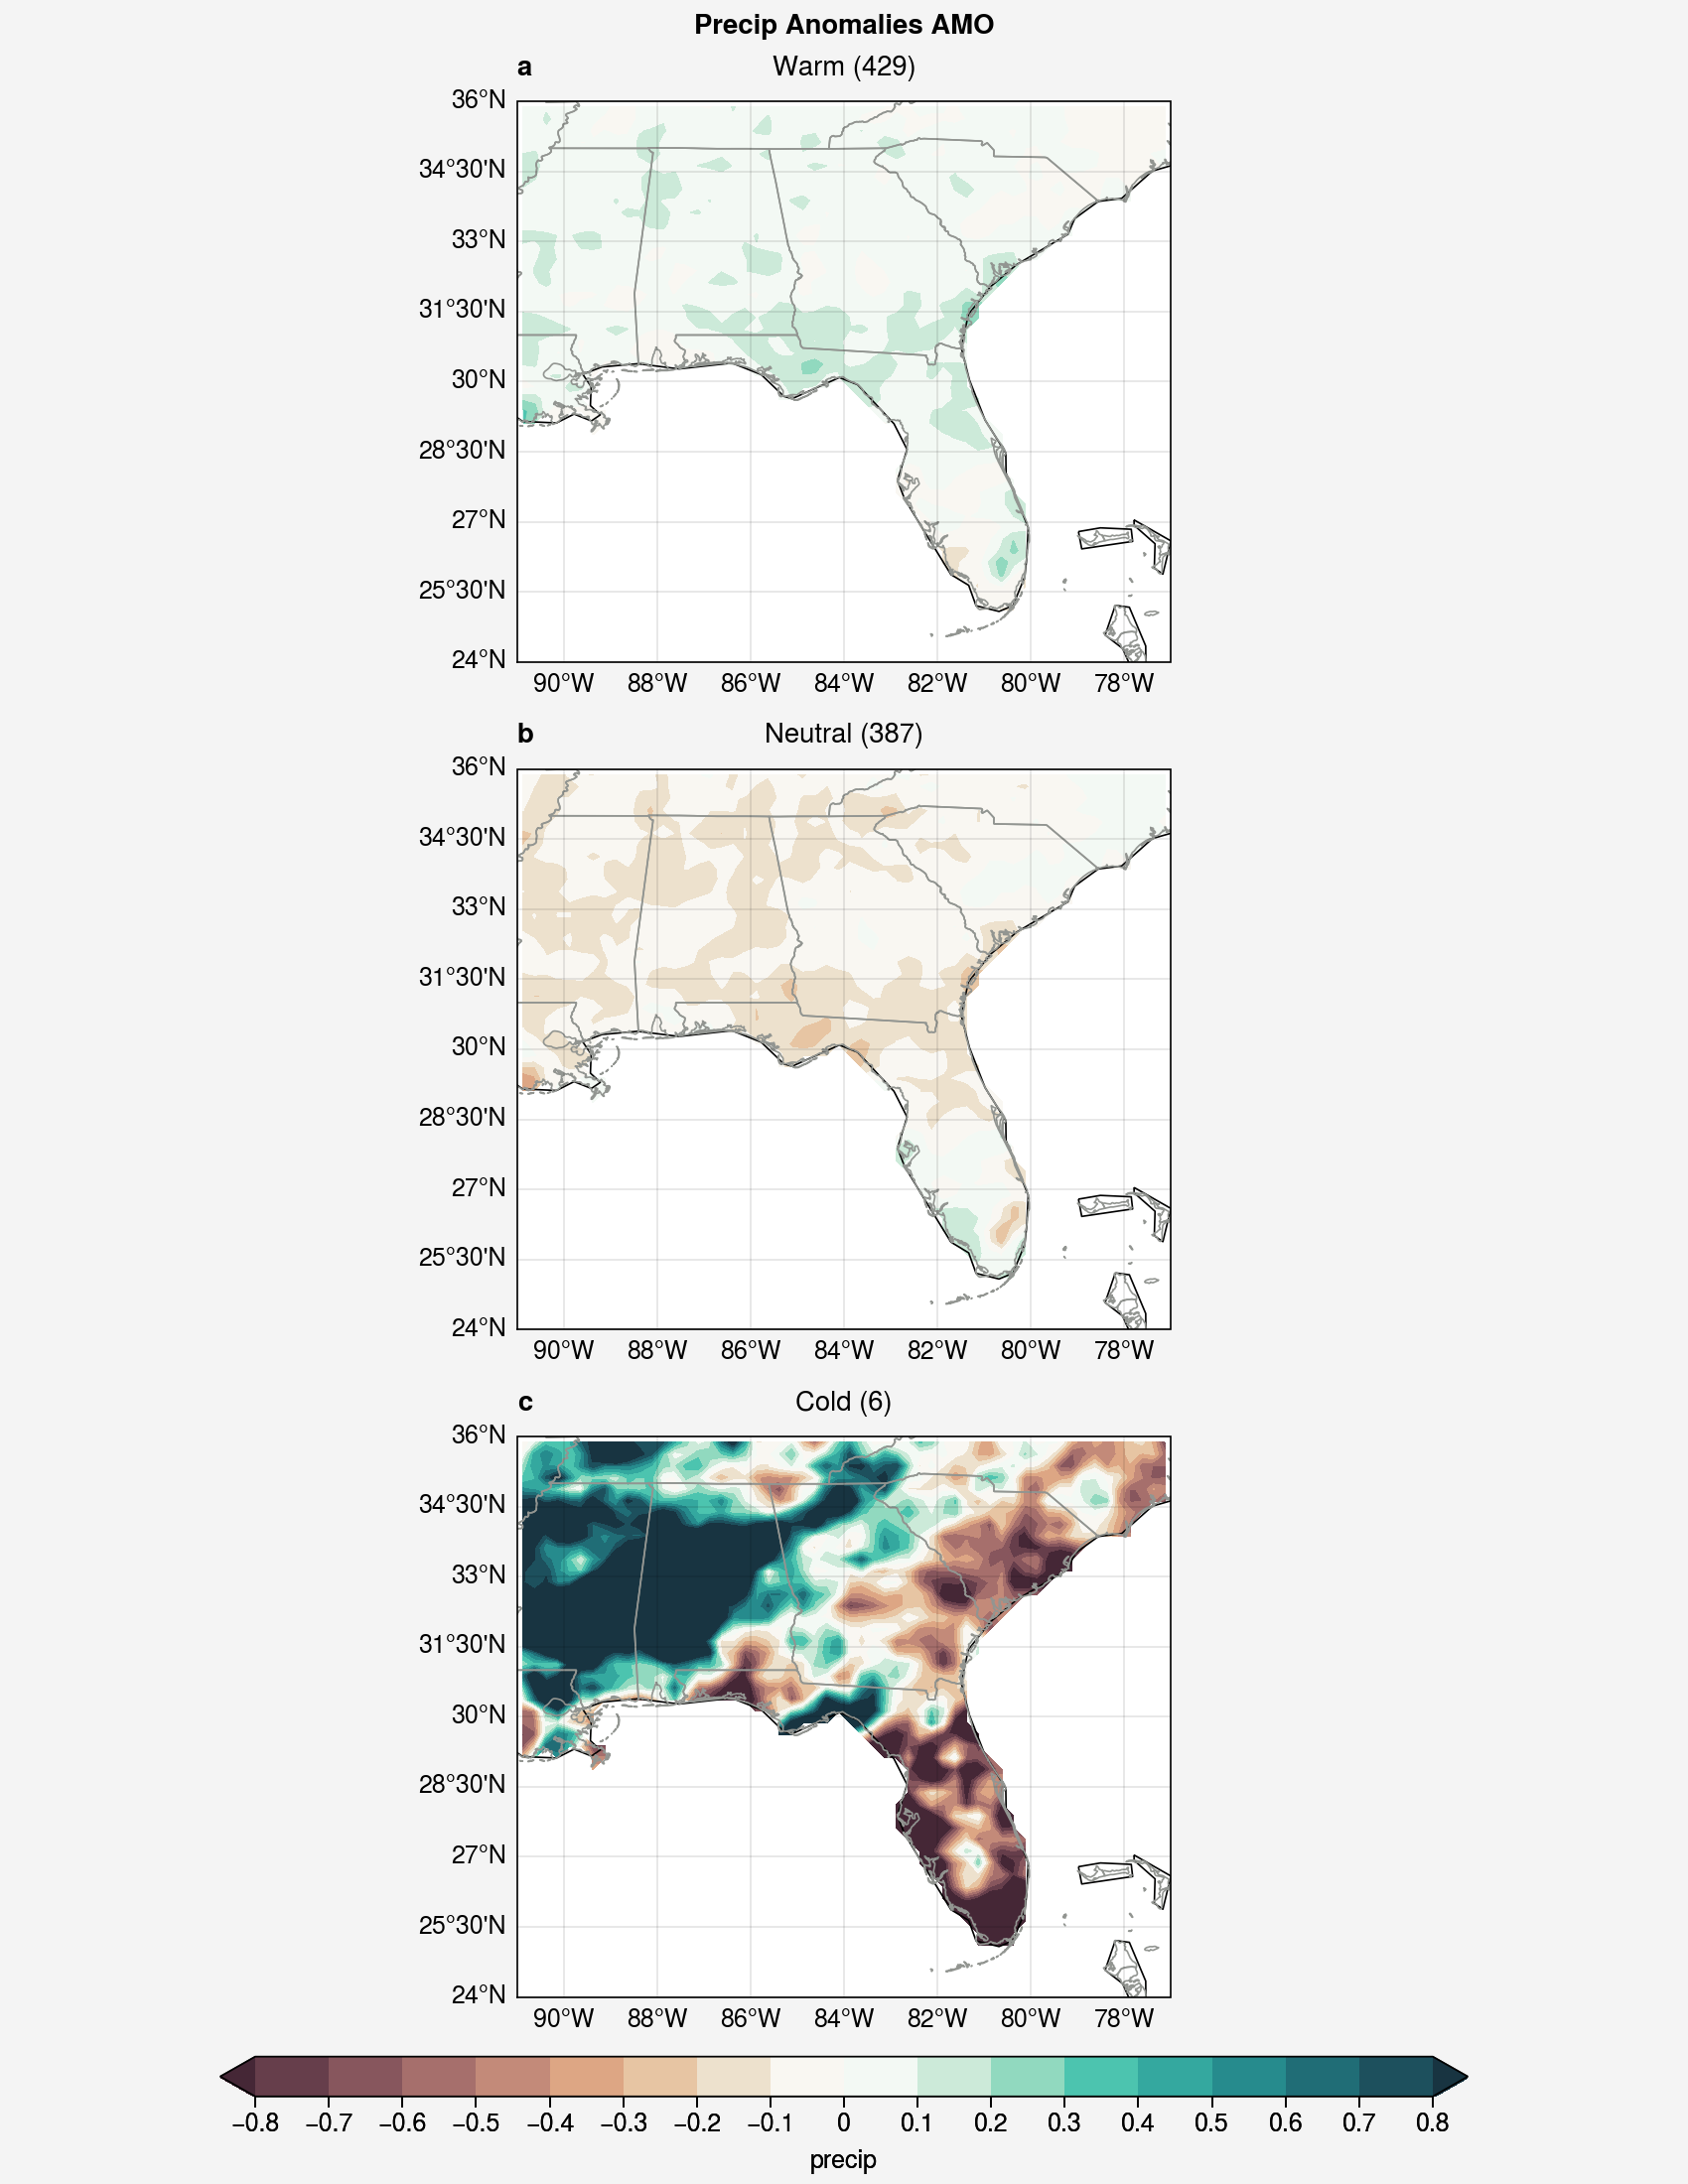

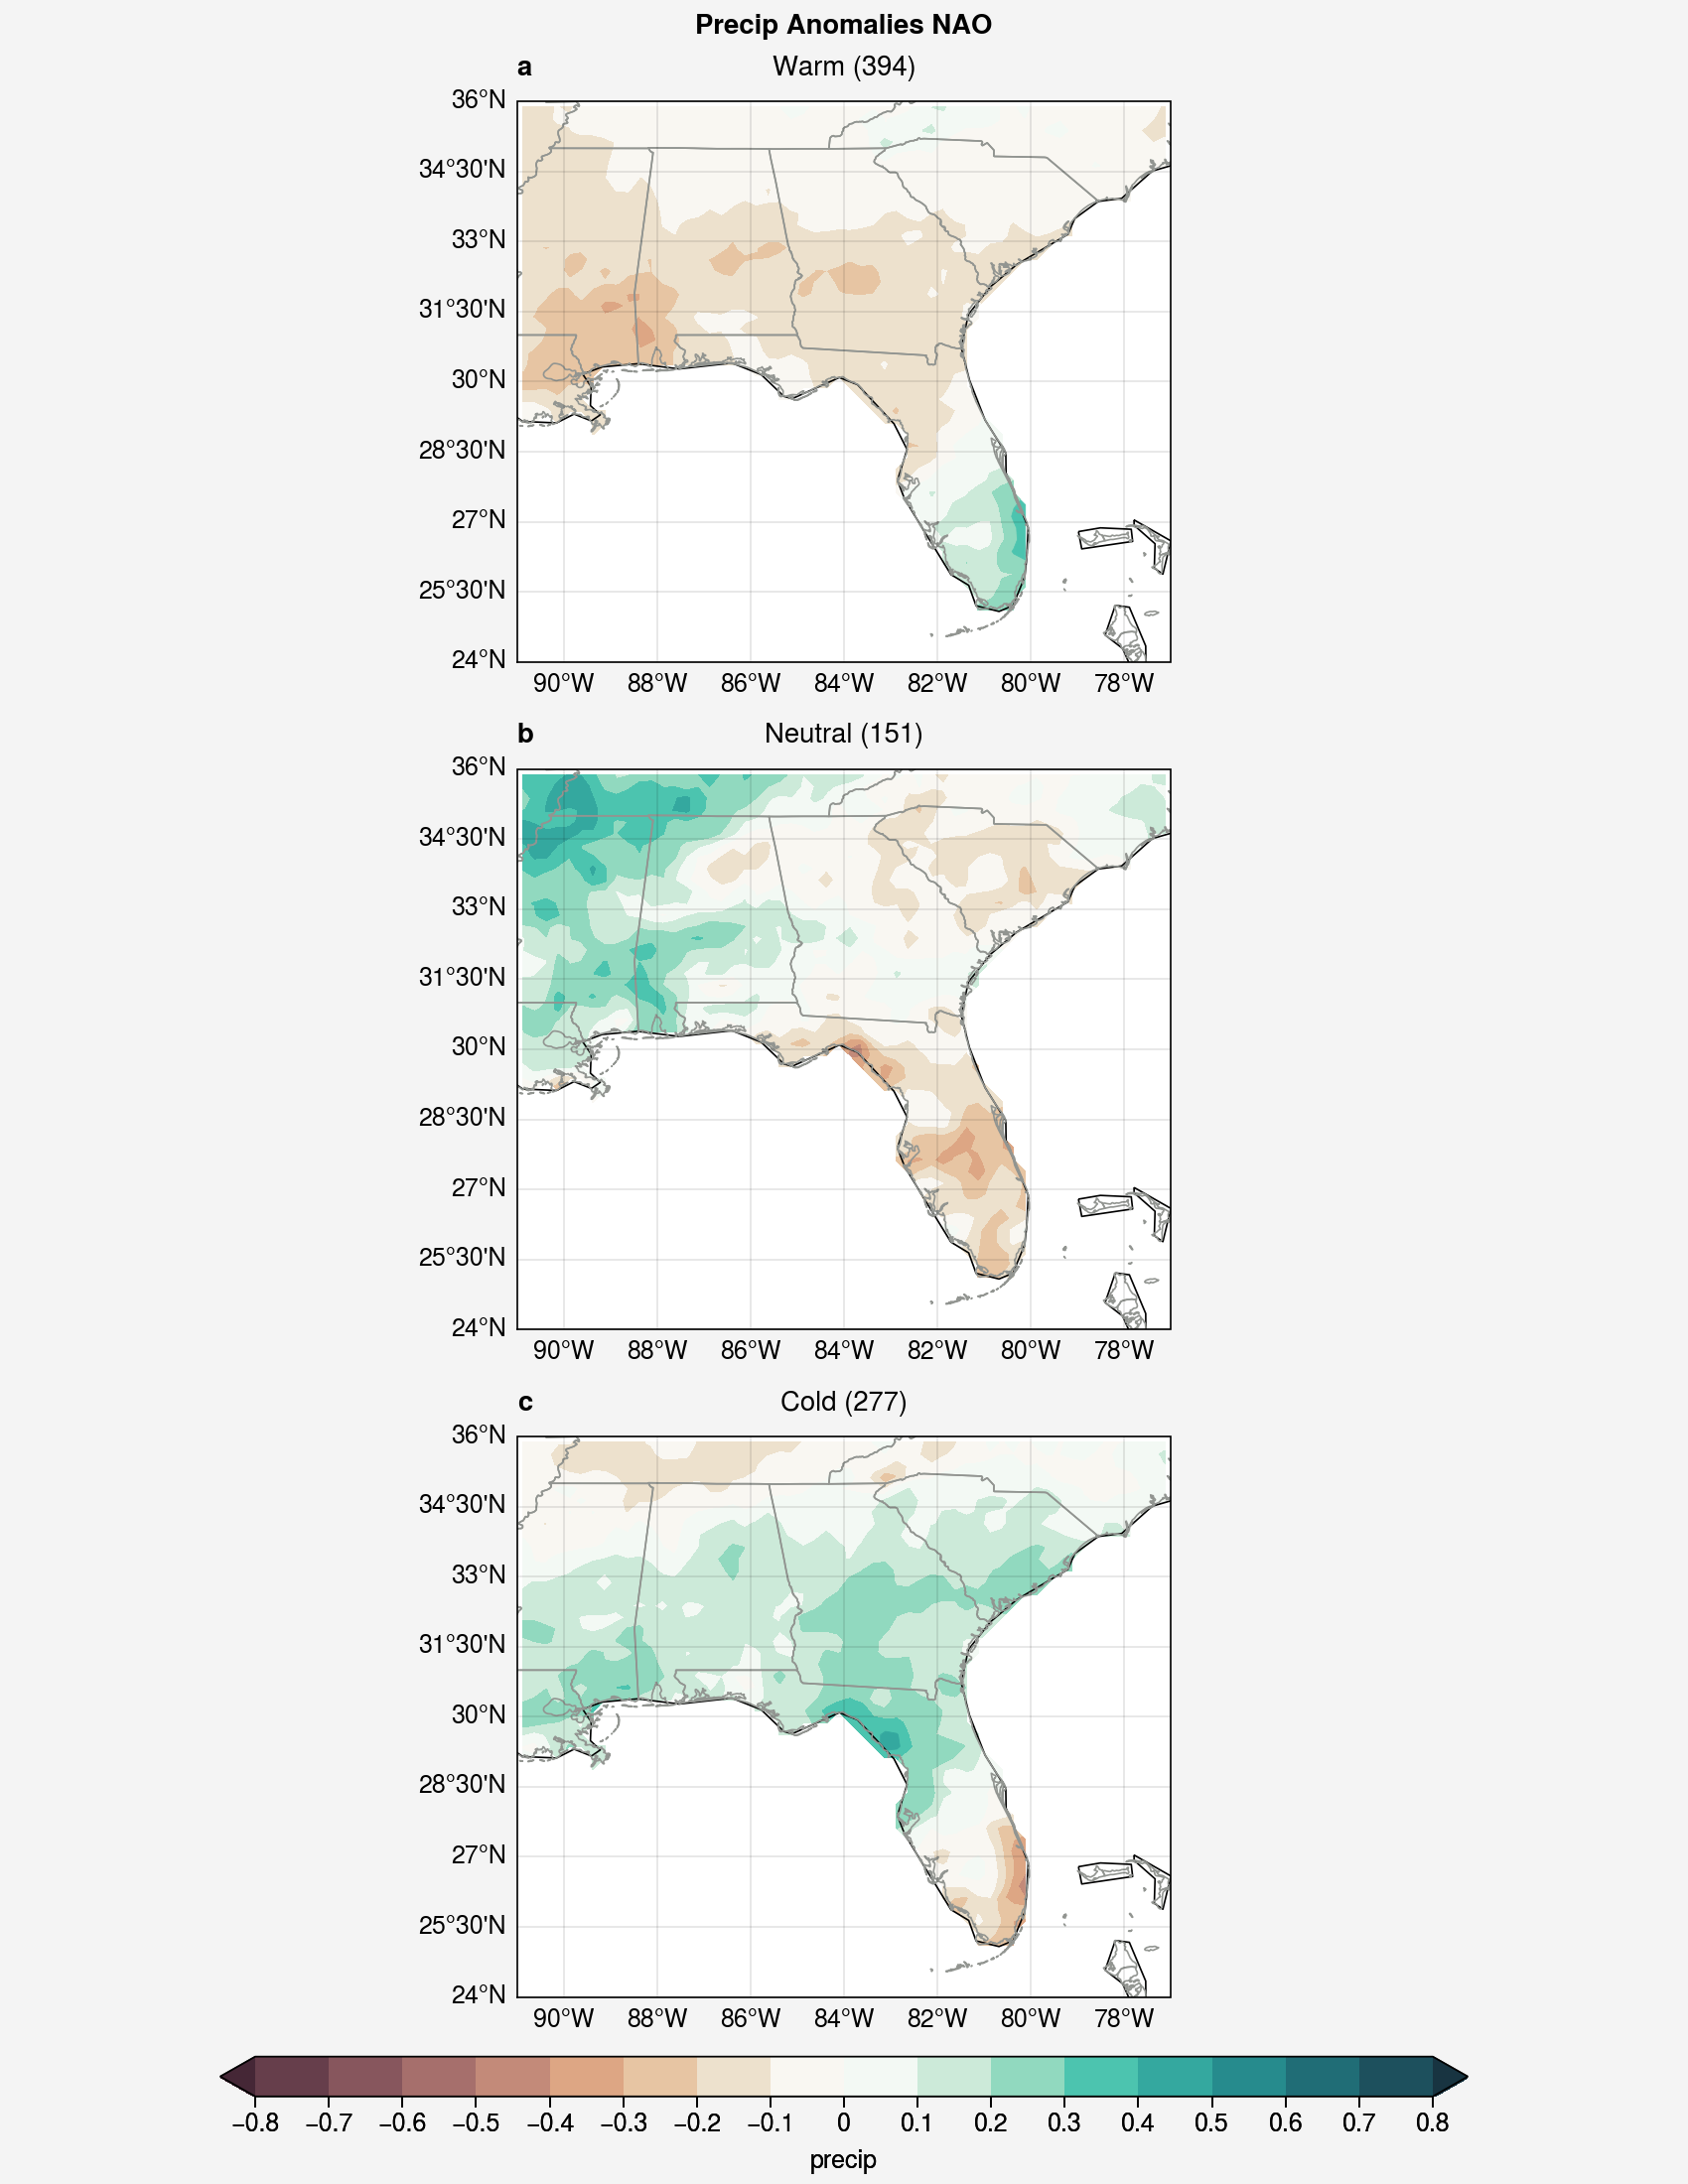

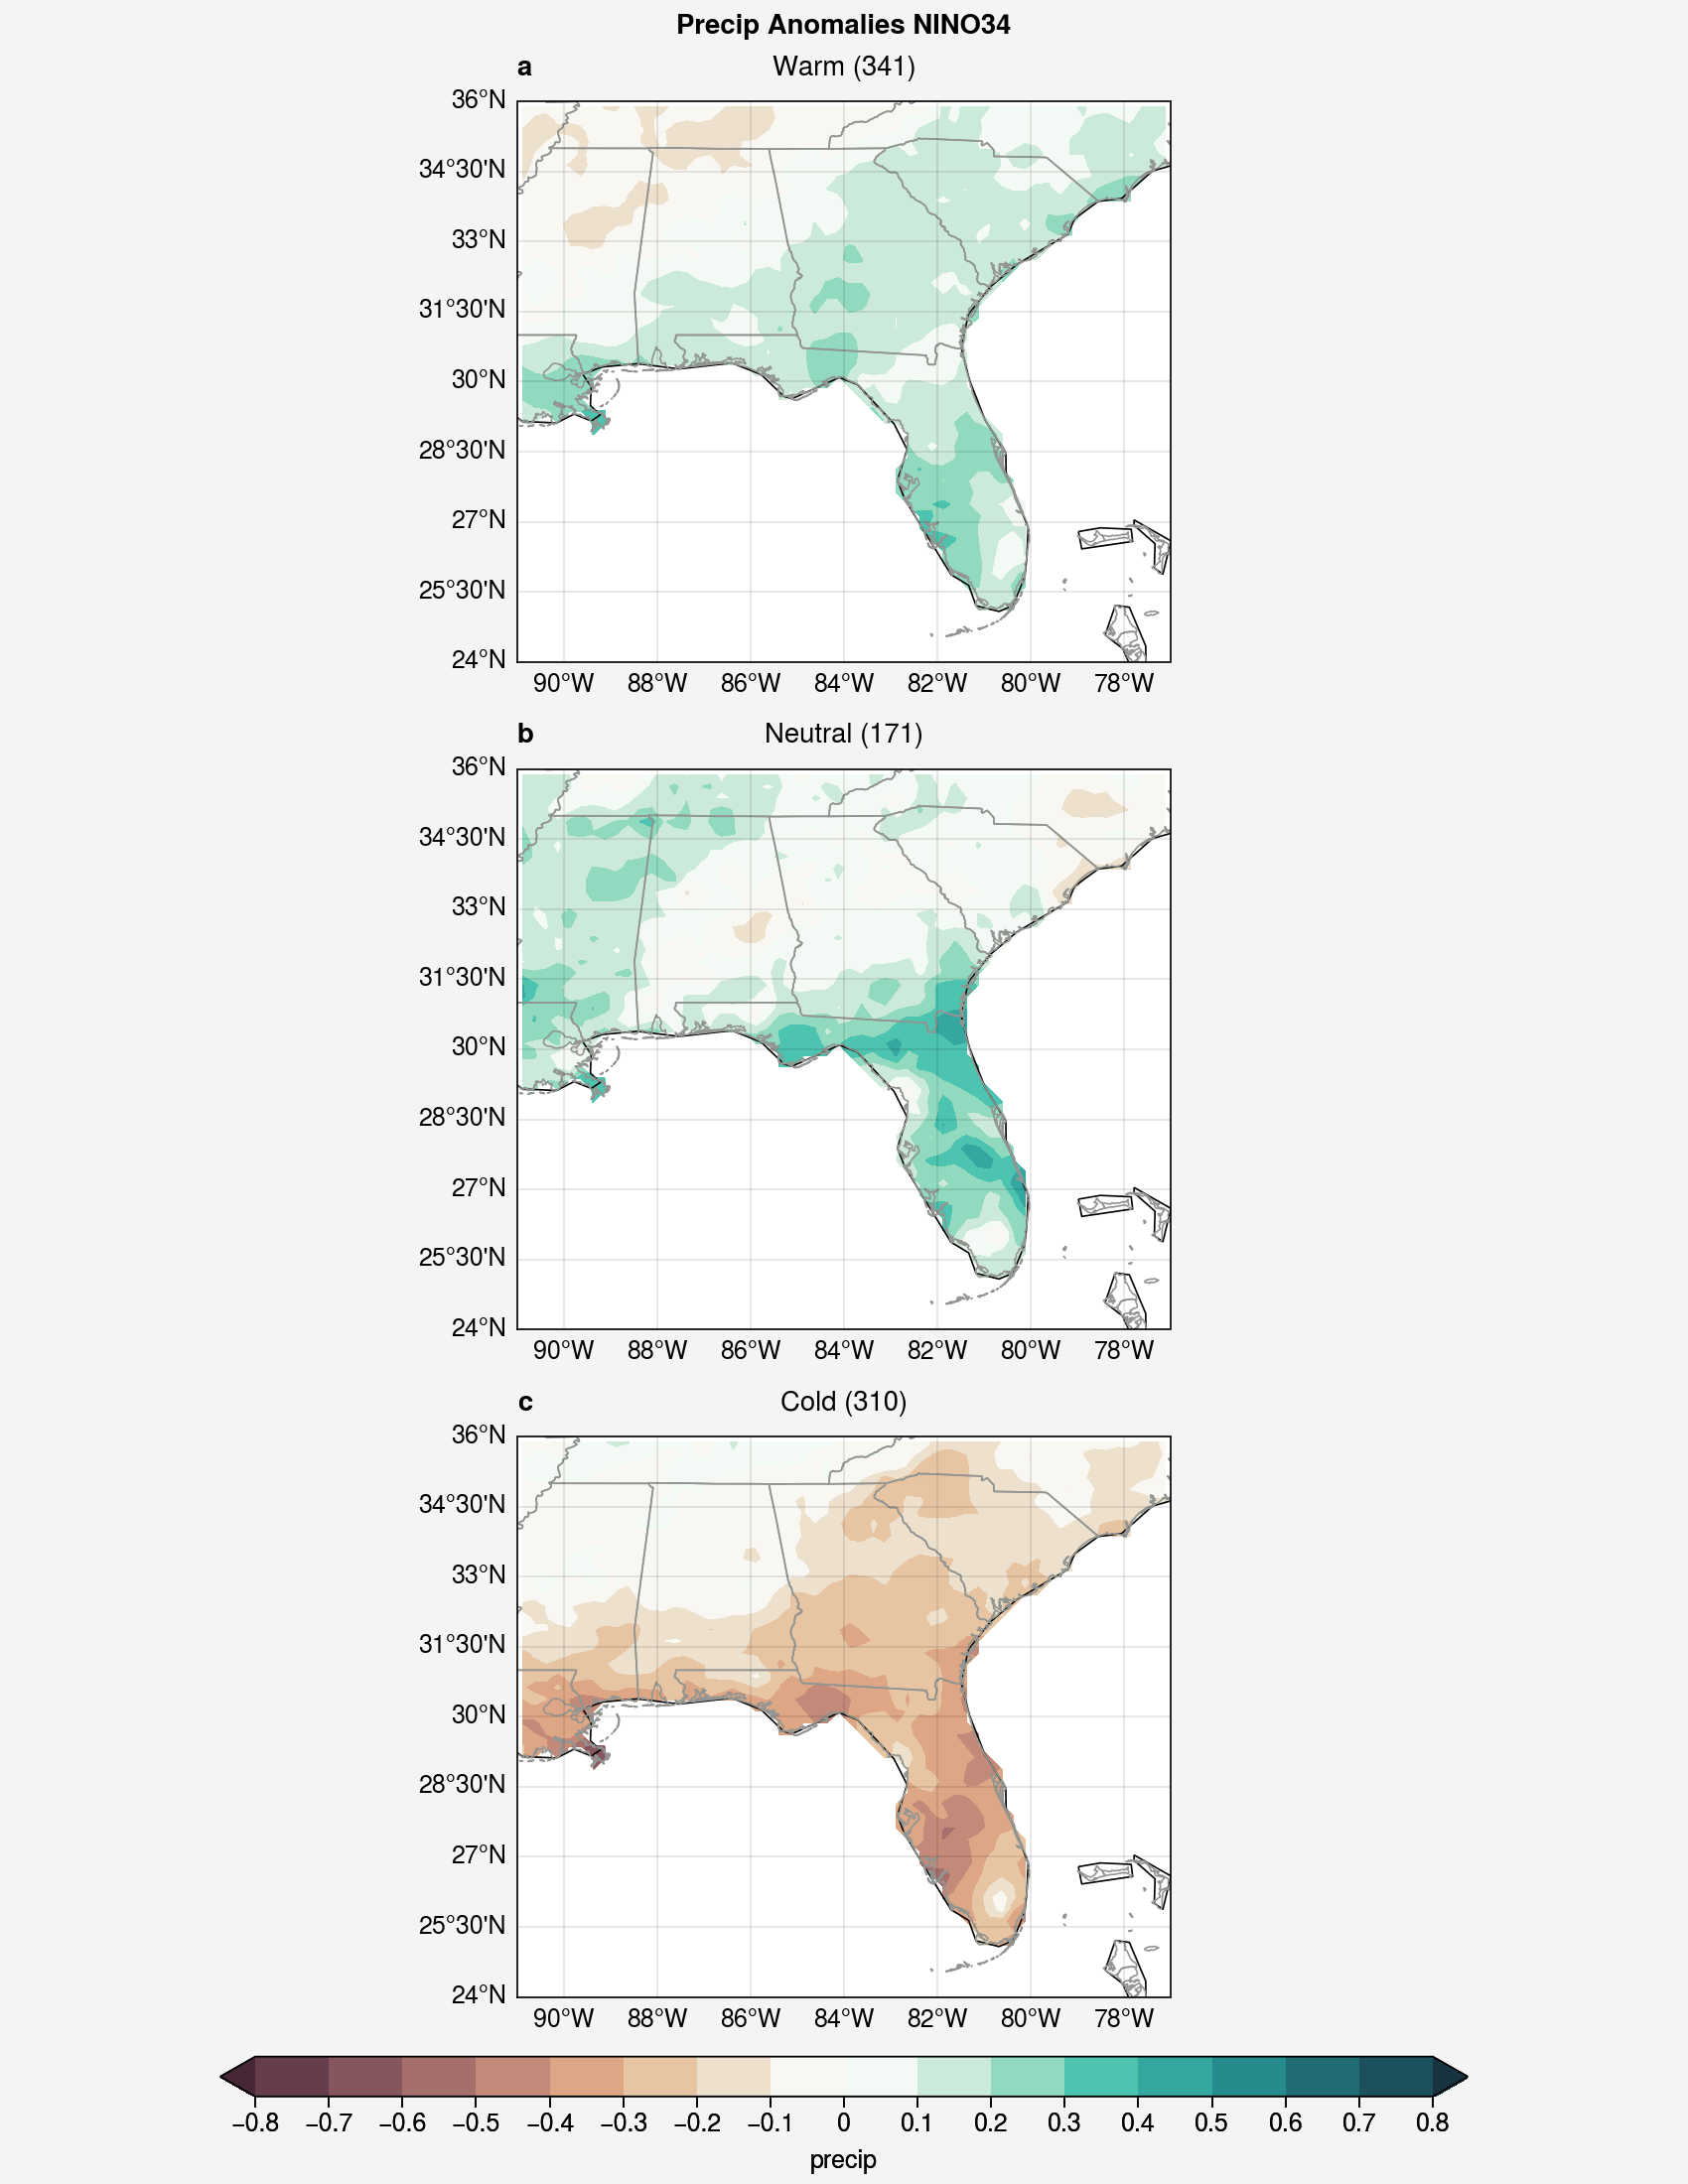

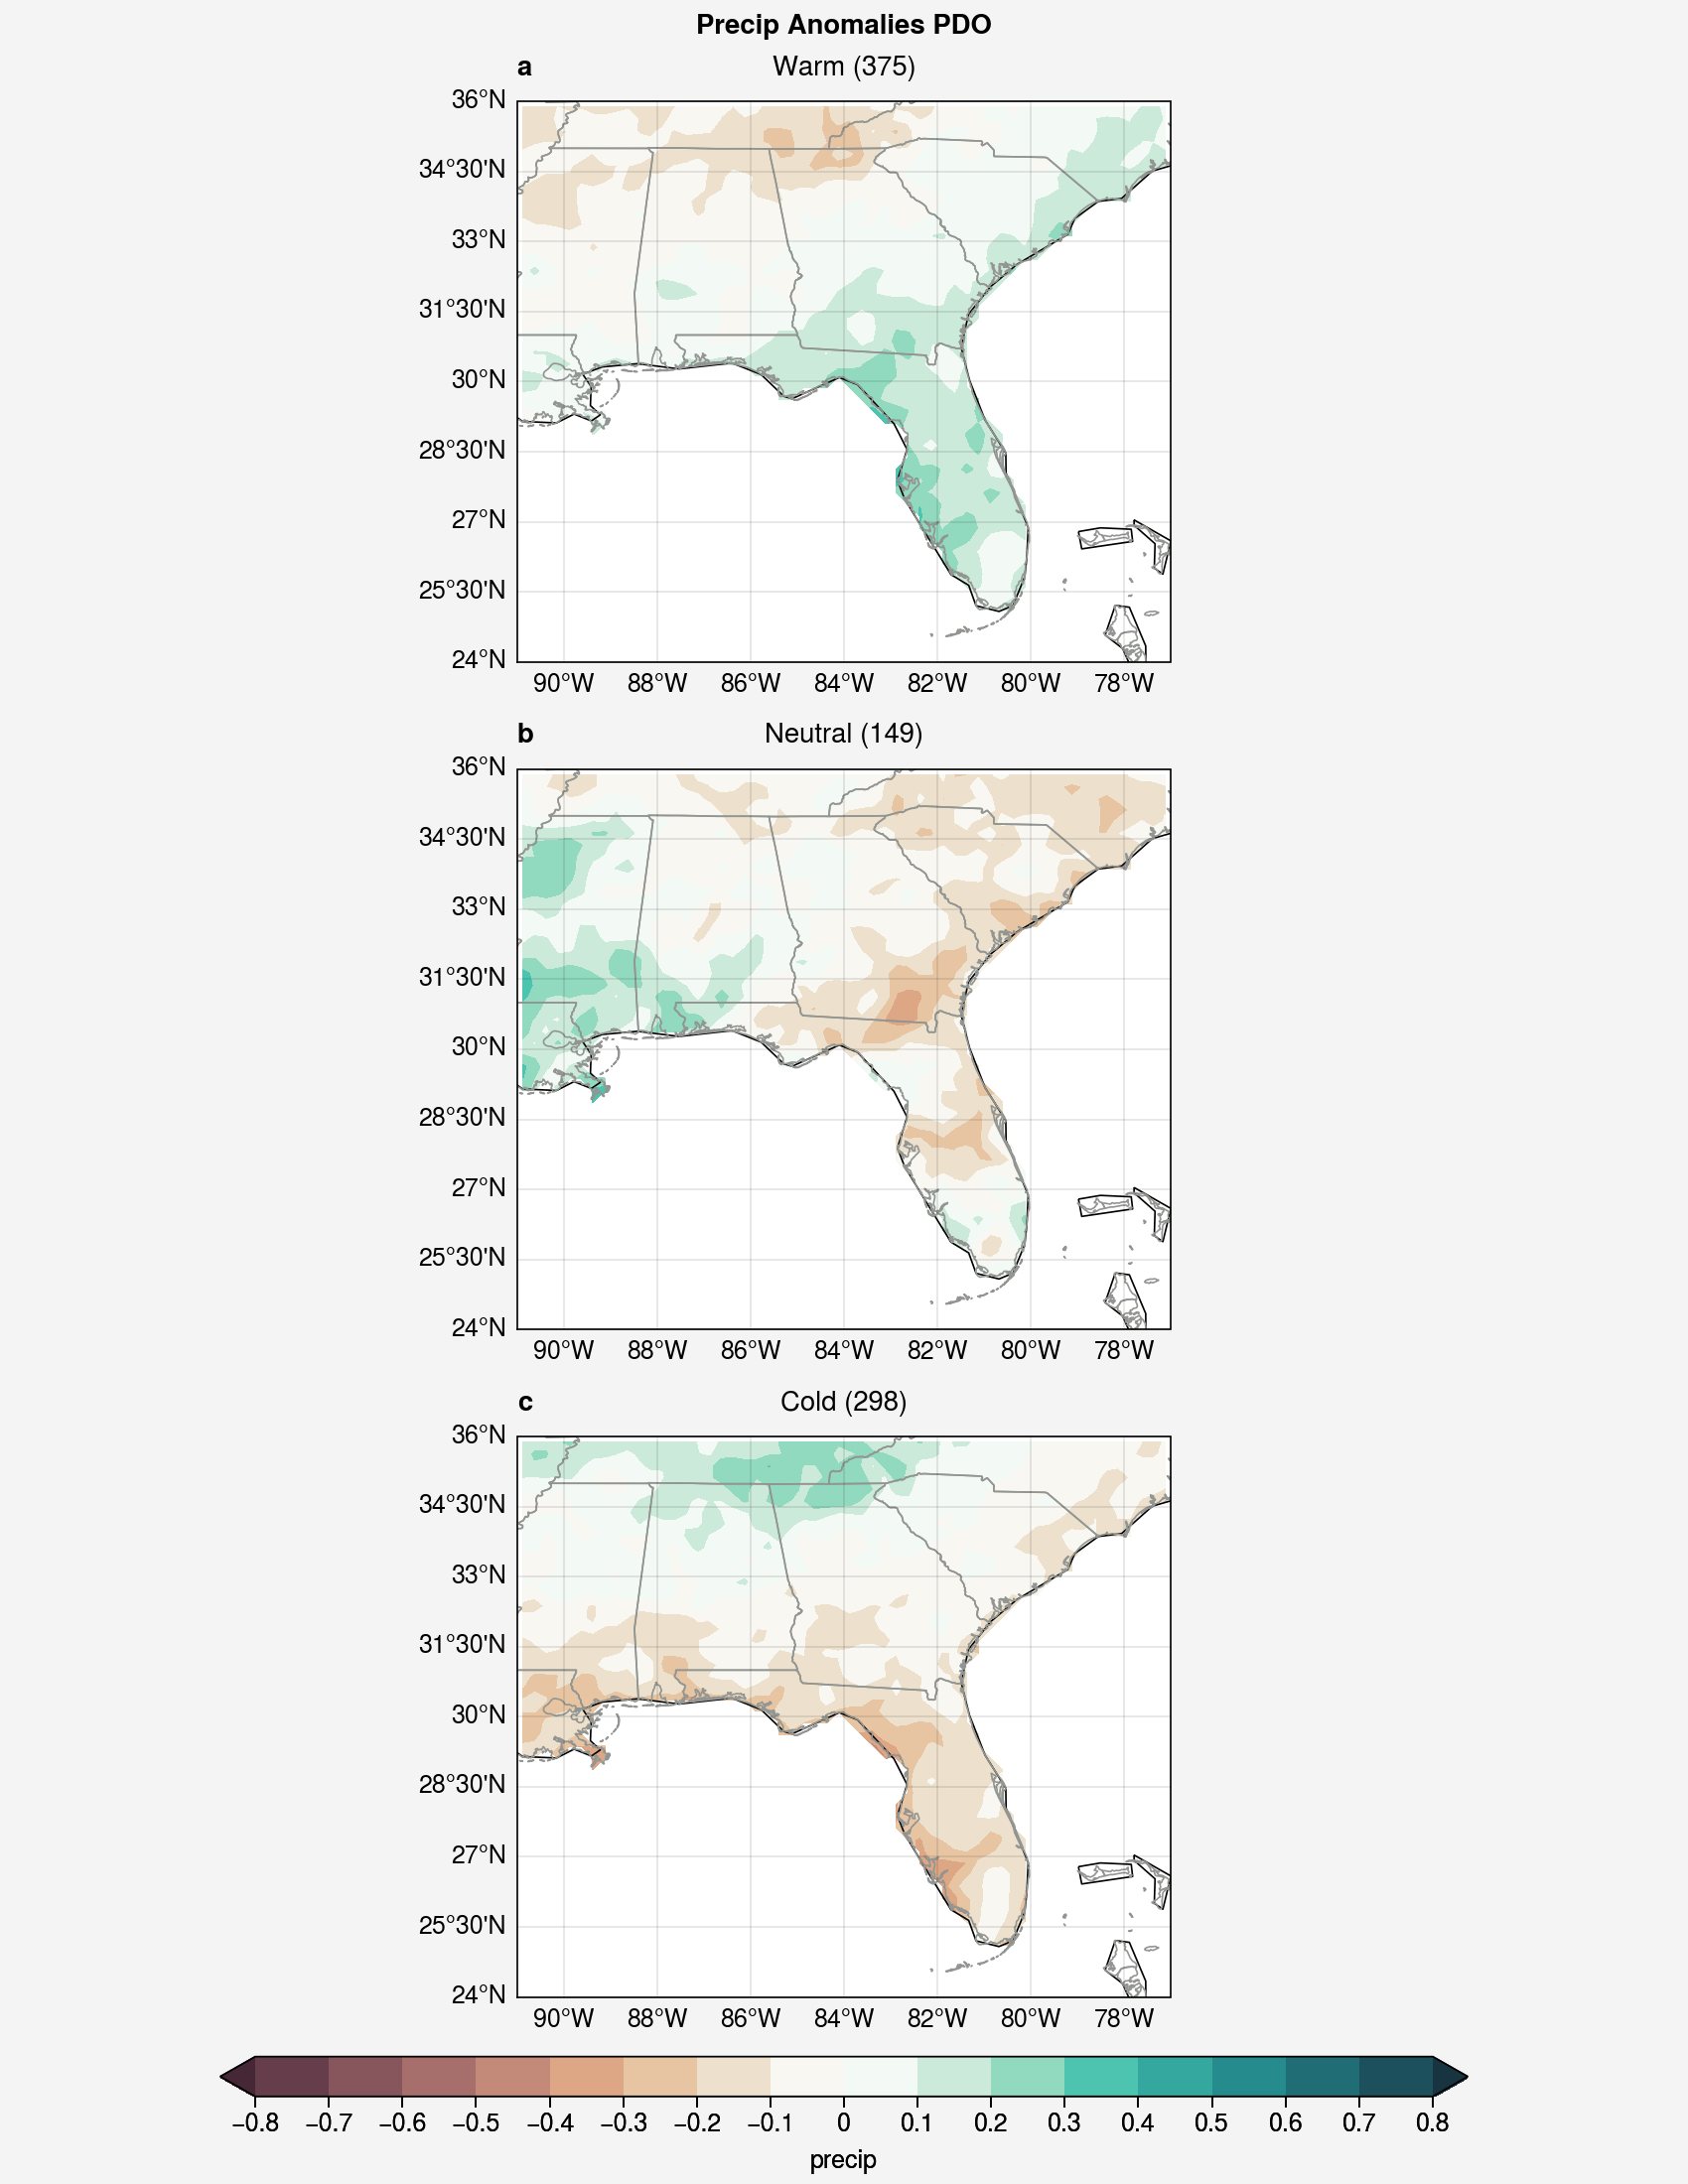

In [12]:
# Colormaps and levels
cmap='DryWet'
clevs=np.arange(-0.8,0.9,0.1)
labels=['Warm','Neutral','Cold']
v='precip'

for i,f in enumerate(indices):
    
    ds_bins=makeBins(ds_indices,f,3)
    ds=xr.merge([ds_anoms,ds_bins])
    ds_comp,totals=calcComposites(ds,f,labels)
    ds_totals=xr.concat(totals,dim='mlso_bins').to_dataset(name='bins_count')
 
    suptitle=v.capitalize()+' Anomalies '+f.upper()
    compfile='../figs/comp_anomaly.'+v+'.'+f+'.png'
    plotComposites(ds_comp,f,totals,suptitle,labels,clevs,cmap,compfile)

    print(ds_comp)

### Setup Features and Target and put into a `numpy` array

* Y (Target) : SEUS (24N-36N; 92W-83W) Precipitation Anomalies

* X (Features) : PDO, Nino34, AMO, NAO

In [13]:
X=np.stack((ds_indices['amo'].values,ds_indices['nao'].values,ds_indices['nino34'],ds_indices['pdo']),axis=-1)
Y=ds_indices['precip'].values

print('Check Features and Target Dimensions')
print('Features (X): ',X.shape)
print('Target (Y): ',Y.shape)

nsamples=X.shape[0]
nfeatures=X.shape[1]

print("Samples: ",nsamples)
print("Features: ", nfeatures)

Check Features and Target Dimensions
Features (X):  (822, 4)
Target (Y):  (822,)
Samples:  822
Features:  4


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8,shuffle=False)

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

print('Training Size: ',ntrain)
print('Testing Size: ',ntest)

Training Size:  657
Testing Size:  165


### Take a look at training data & Relationships between variables
Mean, Variance, Trend

Check Stats:  Index:  amo Mean:  -0.05817960426179604 Var:  0.04204310016240047
Check Stats:  Index:  nao Mean:  -0.06487062404870624 Var:  1.160459990872213
Check Stats:  Index:  nino34 Mean:  -0.21519025875190262 Var:  0.7615114173784719
Check Stats:  Index:  pdo Mean:  -0.08111111111111109 Var:  1.2386077456451885


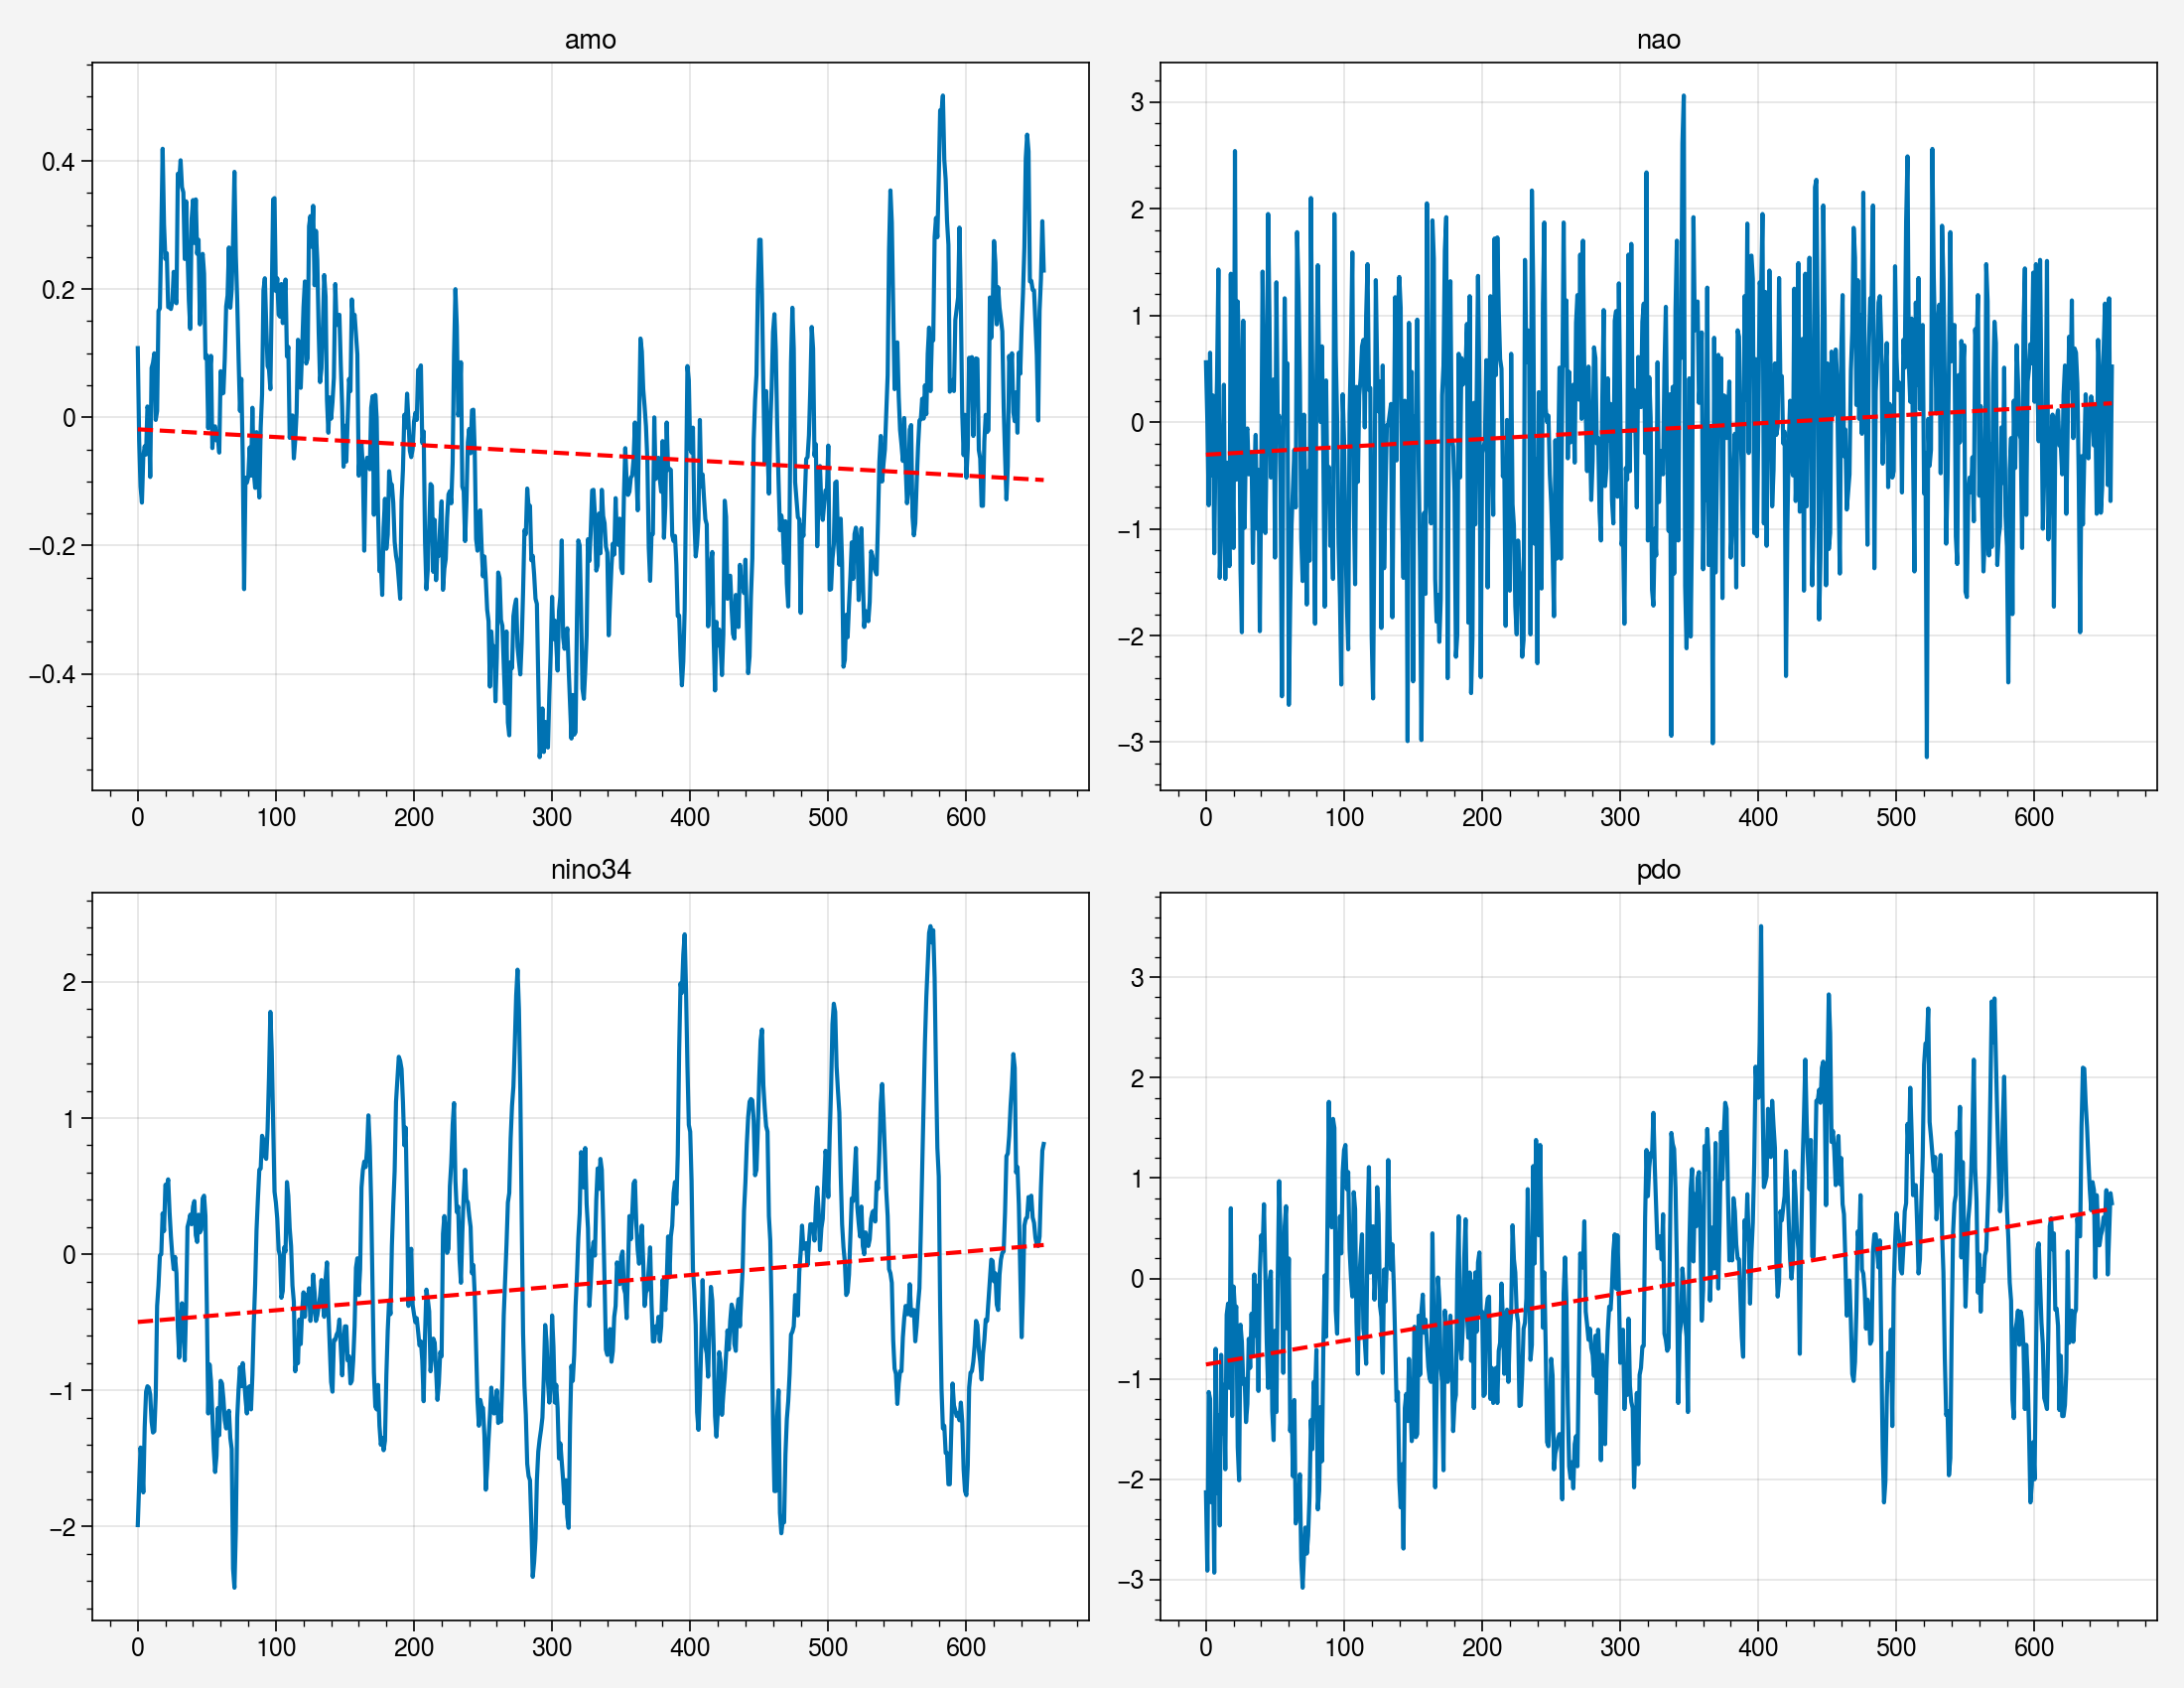

In [15]:
plt.figure(figsize=(11,8.5))
y=np.arange(ntrain)

for i,f in enumerate(indices):

    plt.subplot(2,2,i+1)

    z = np.polyfit(y,X_train[:,i],1)
    p = np.poly1d(z)
    
    plt.plot(y,X_train[:,i])
    plt.plot(p(y),"r--")
    plt.title(f)

    print("Check Stats: ", "Index: ",f, "Mean: ", X_train[:,i].mean(axis=0),"Var: ", X_train[:,i].var(axis=0))
plt.tight_layout()  

### Standardize Training and Test Data (probably should detrend also)

In [16]:
Xtrain_scaled=(X_train-X_train.mean(axis=0))/X_train.std(axis=0)
Ytrain_scaled=(Y_train-Y_train.mean(axis=0))/Y_train.std(axis=0)
Xtest_scaled=(X_test-X_train.mean(axis=0))/X_train.std(axis=0)
Ytest_scaled=(Y_test-Y_train.mean(axis=0))/Y_train.std(axis=0)

Check Stats:  Index:  amo Mean:  -8.651966341066668e-17 Var:  0.9999999999999993
Check Stats:  Index:  nao Mean:  6.488974755800001e-17 Var:  0.9999999999999994
Check Stats:  Index:  nino34 Mean:  -4.325983170533334e-17 Var:  0.9999999999999998
Check Stats:  Index:  pdo Mean:  -8.651966341066668e-17 Var:  0.9999999999999976


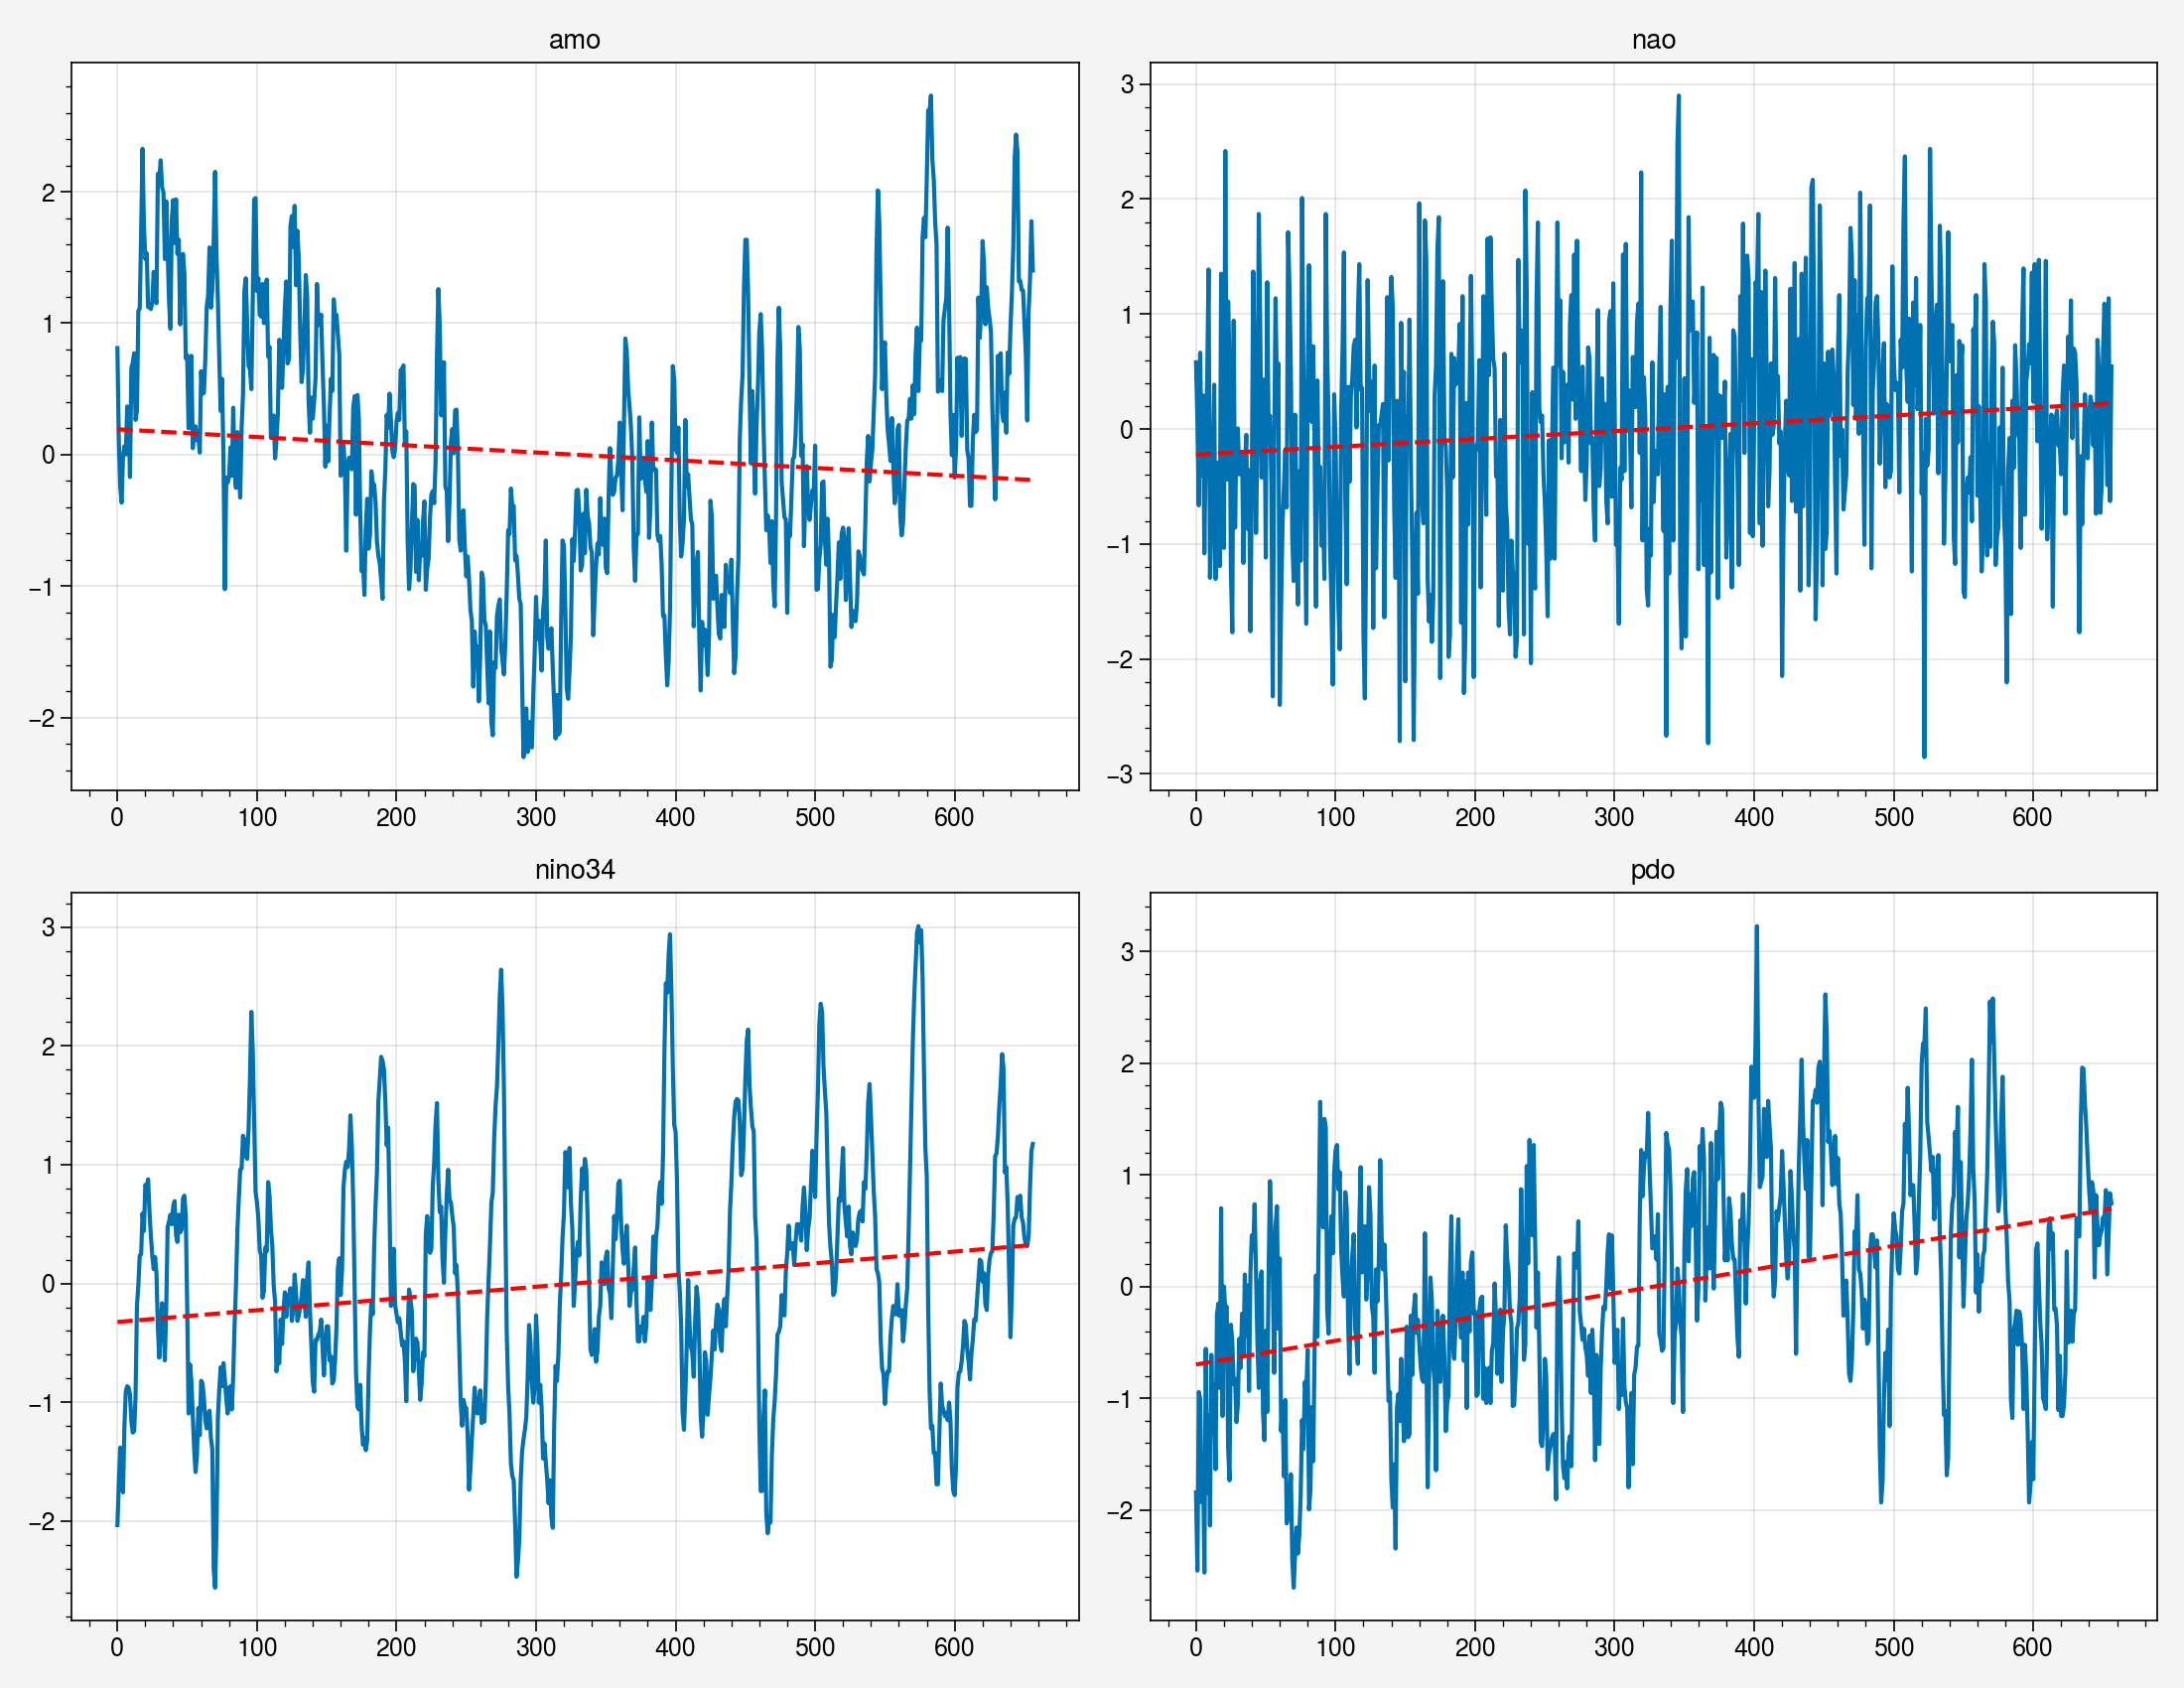

In [17]:
plt.figure(figsize=(11,8.5))
y=np.arange(ntrain)

for i,f in enumerate(indices):

    plt.subplot(2,2,i+1)

    z = np.polyfit(y,Xtrain_scaled[:,i],1)
    p = np.poly1d(z)
    
    plt.plot(y,Xtrain_scaled[:,i])
    plt.plot(p(y),"r--")
    plt.title(f)

    print("Check Stats: ", "Index: ",f, "Mean: ", Xtrain_scaled[:,i].mean(axis=0),"Var: ", Xtrain_scaled[:,i].var(axis=0))
plt.tight_layout()  

## Make heatmap of Training Data

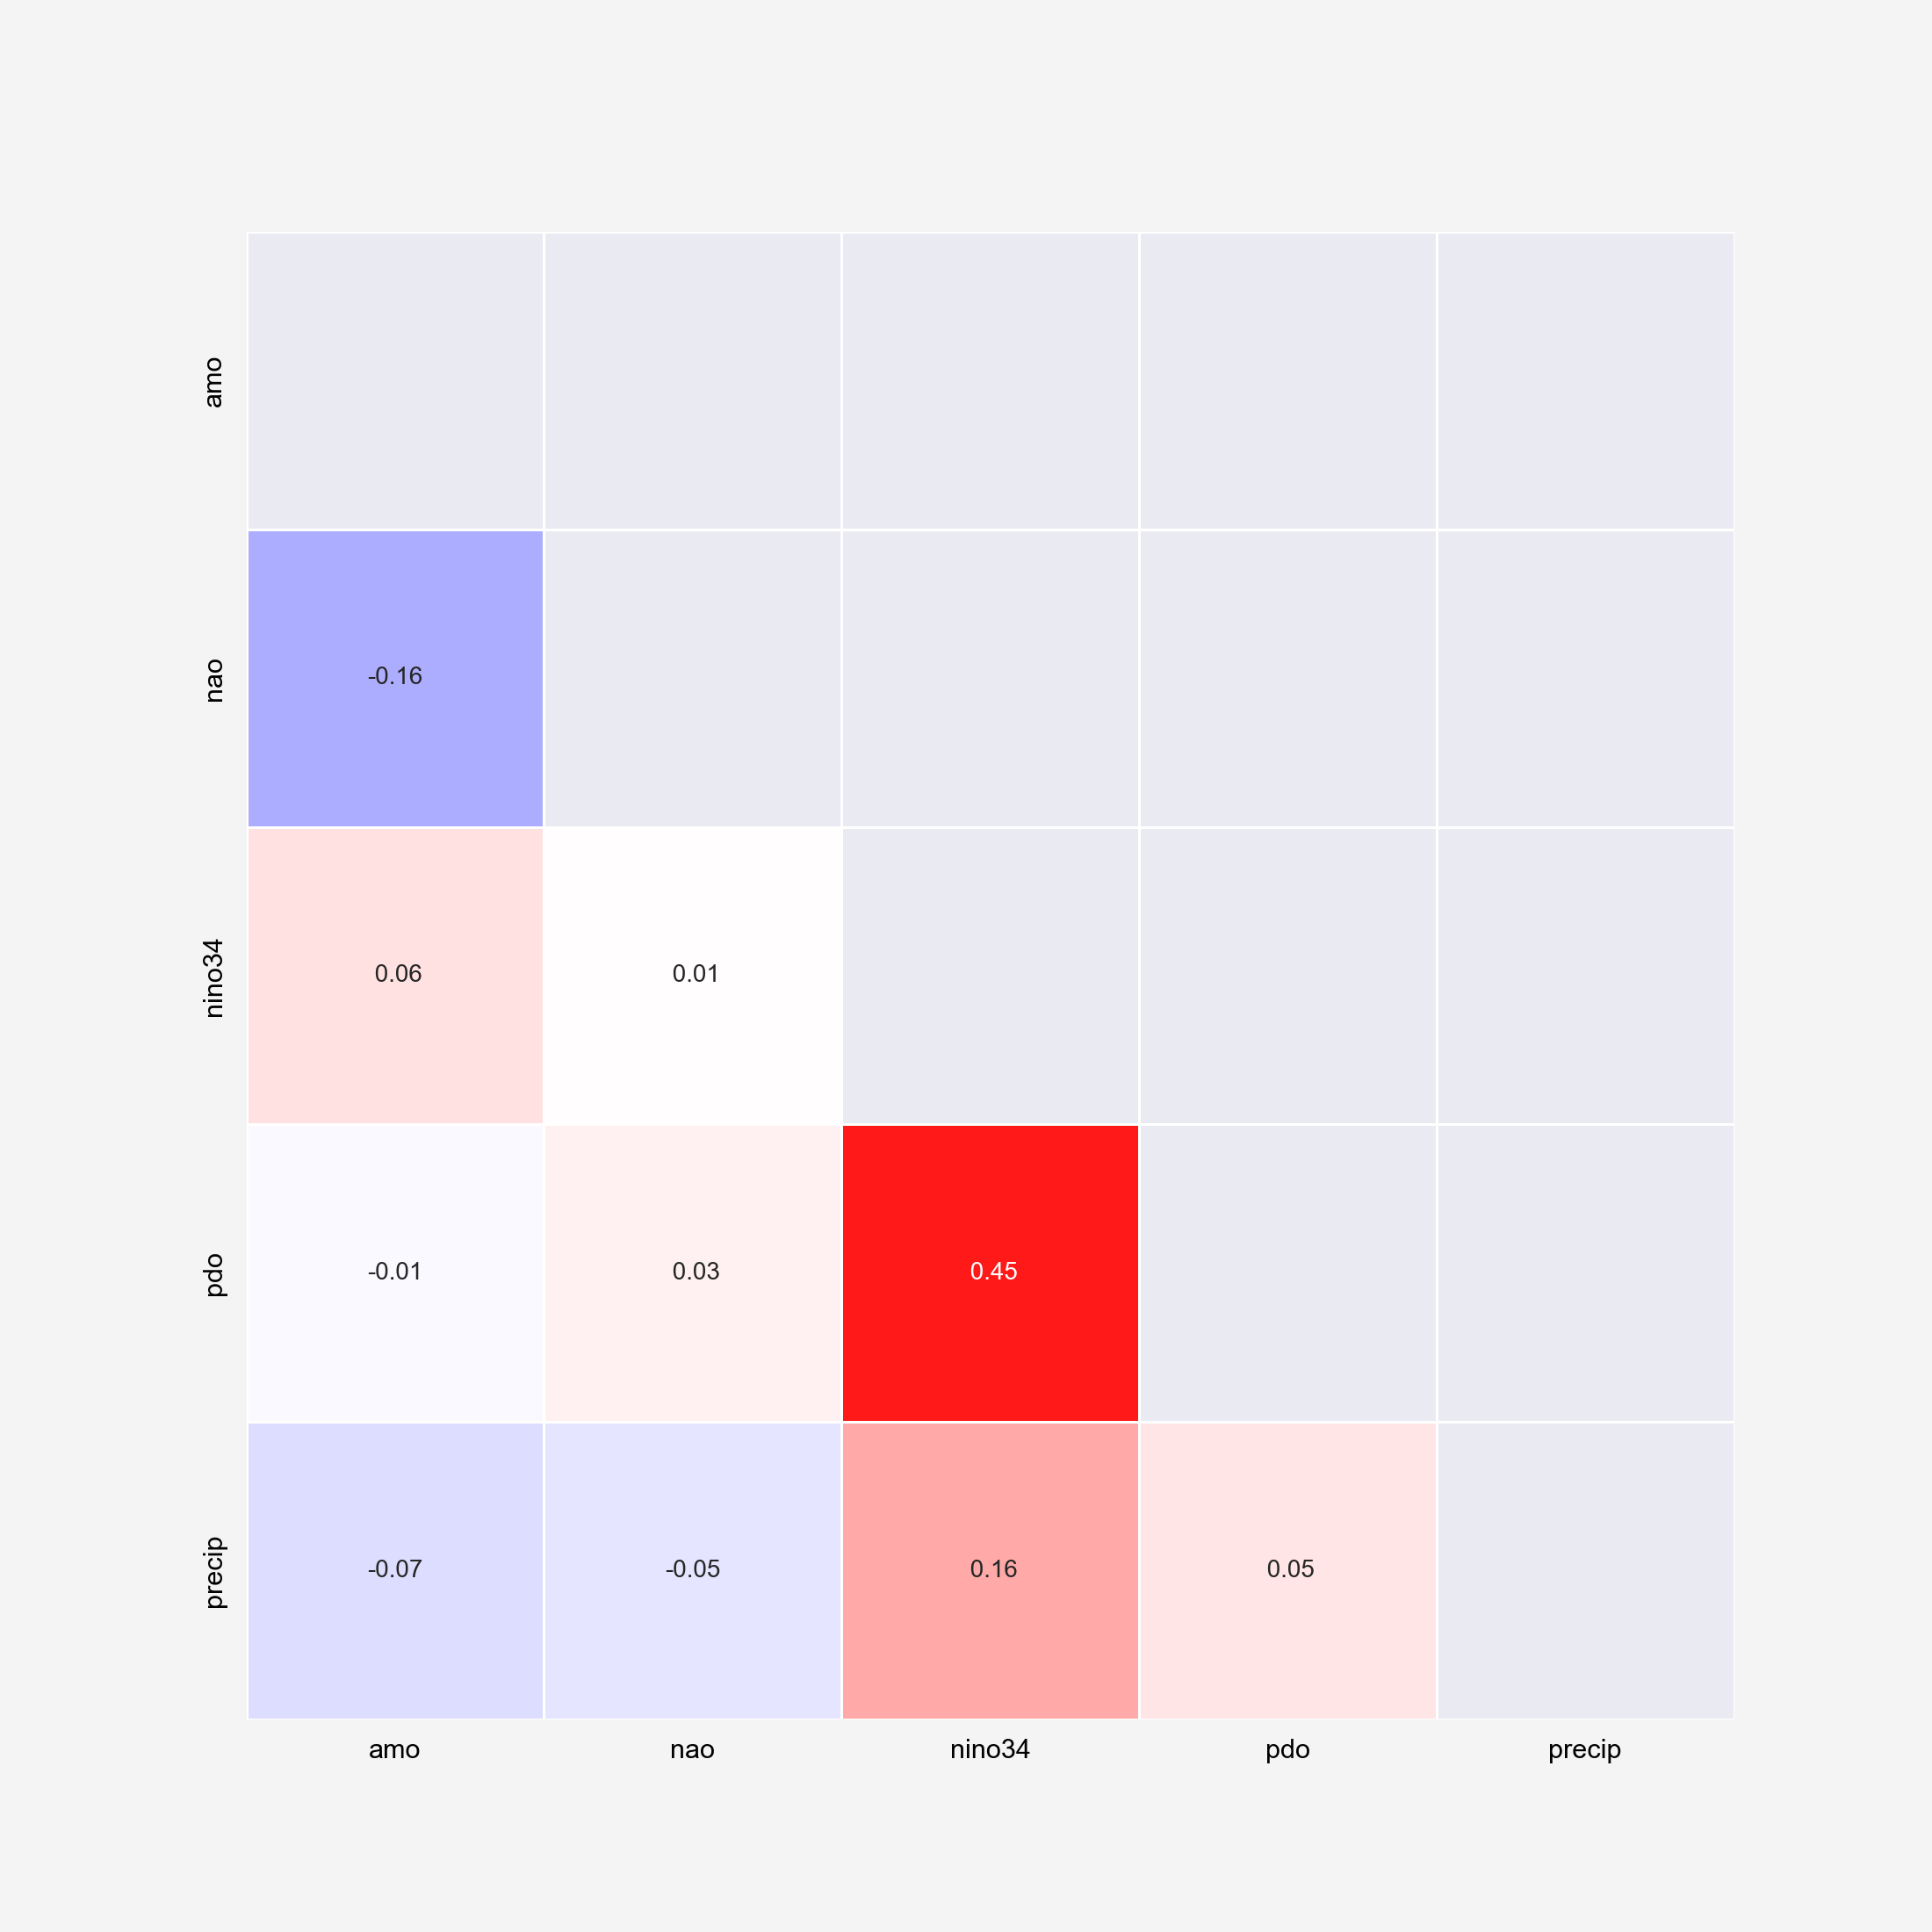

In [18]:
heatmap(Xtrain_scaled,Ytrain_scaled,list(ds_indices.keys()))

### Put Training Data into `xarray.Dataset`

In [19]:
ds_Xtrain_list=[]
for i,f in enumerate(indices):
    
    ds_Xtrain_list.append(xr.DataArray(Xtrain_scaled[:,i],
                          coords={'time':ds_indices['time'][0:ntrain].values},
                          dims=['time']).to_dataset(name=f))
    
ds_Xtrain=xr.merge(ds_Xtrain_list)

ds_Ytrain=xr.DataArray(Ytrain_scaled,
                       coords={'time':ds_indices['time'][0:ntrain].values},
                       dims=['time']).to_dataset(name='precip')
print(ds_Ytrain)

ds_train=xr.merge([ds_Xtrain,ds_Ytrain])
ds_train

<xarray.Dataset>
Dimensions:  (time: 657)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2004-09-01
Data variables:
    precip   (time) float32 -0.09401 -0.7155 0.4258 ... -0.4902 0.5184 2.159


<xarray.Dataset>
Dimensions:  (time: 657)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2004-09-01
Data variables:
    amo      (time) float64 0.8105 0.1082 -0.243 -0.3649 ... 1.337 1.776 1.401
    nao      (time) float64 0.5801 0.0695 -0.6638 ... 1.137 -0.6267 0.5429
    nino34   (time) float64 -2.034 -1.69 -1.381 -1.518 ... 0.8081 1.118 1.175
    pdo      (time) float64 -1.841 -2.542 -0.9425 ... 0.4682 0.8366 0.7468
    precip   (time) float32 -0.09401 -0.7155 0.4258 ... -0.4902 0.5184 2.159

# How well can we predict SEUS Rainfall Index with these indices?

### Train Models

In [20]:
regr_lr,coeffs_lr,rsq_train_lr,Ypred_lr=lr(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train Standard : ', rsq_train_lr)
regr_lasso,coeffs_lasso,rsq_train_lasso,Ypred_lasso=lasso(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train LASSO : ', rsq_train_lasso)
regr_ridge,coeffs_ridge,rsq_train_ridge,Ypred_ridge=ridge(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train Ridge : ', rsq_train_ridge)
nn=tomsensomodel_regression(Xtrain_scaled,Ytrain_scaled)
rsq_train_nn,Y_pred_train_nn=get_r2(Xtrain_scaled,Ytrain_scaled,nn)
print('R^2 Train NN: ',rsq_train_nn)

R^2 Train Standard :  0.1949637838906977
R^2 Train LASSO :  0.19103487434845895
R^2 Train Ridge :  0.1949582030650922
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
R^2 Train NN:  0.24087228343794412


### Predict for Test Data

In [21]:
rsq_test_lr,Y_pred_test_lr=get_r2(Xtest_scaled,Ytest_scaled,regr_lr)
print('R^2 Test Standard: ',rsq_test_lr)

rsq_test_lasso,Y_pred_test_lasso=get_r2(Xtest_scaled,Ytest_scaled,regr_lasso)
print('R^2 Test Lasso: ',rsq_test_lasso)

rsq_test_ridge,Y_pred_test_ridge=get_r2(Xtest_scaled,Ytest_scaled,regr_ridge)
print('R^2 Test Ridge: ',rsq_test_lr)

rsq_test_nn,Y_pred_test_nn=get_r2(Xtest_scaled,Ytest_scaled,nn)
print('R^2 Test NN: ',rsq_test_nn)

R^2 Test Standard:  0.25290432741682467
R^2 Test Lasso:  0.2564461019129807
R^2 Test Ridge:  0.25290432741682467
R^2 Test NN:  0.28037435594318144


### Plot coefficients for standard linear regression

<BarContainer object of 4 artists>

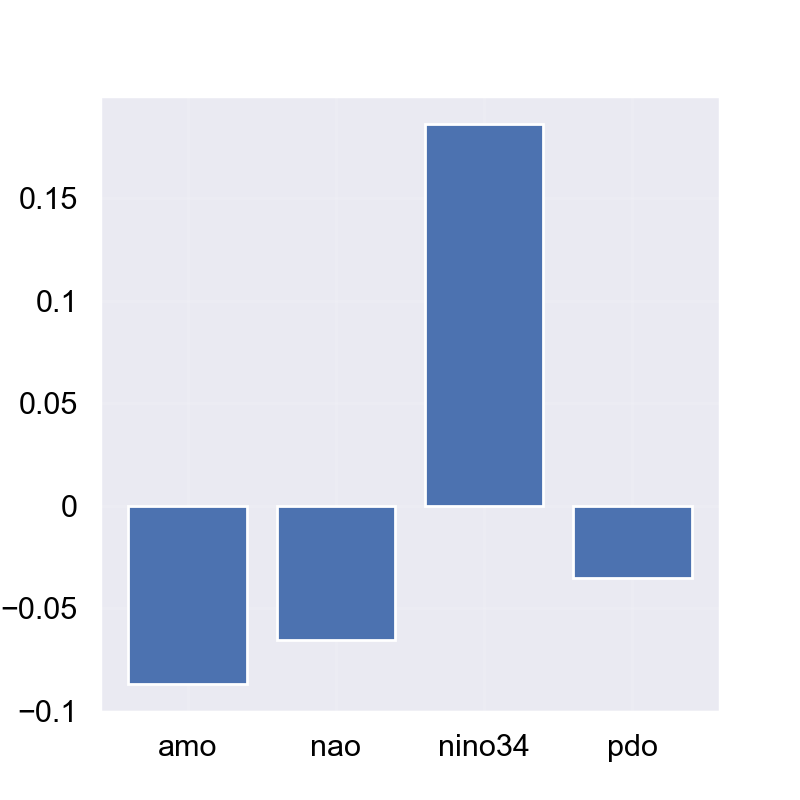

In [22]:
plt.bar(indices,coeffs_lr)